# # Resample audio files

Next code reads audio files and resample them.

1- Reads the audio files sampled at 22050 Hz in path output_podcast_XXXXX/high_score_clips_22050

2- Then it looks for the file in the corresponding path output_podcast_XXXXX/high_score_clips. It is suposed that the files here are the originals that then they were sampled at 22050 Hz. The idea of this code is resample them to 44100 Hz.

3- Reads the audio file and resample it to 44100 Hz. Then it saves it in output_podcast_XXXXX/high_score_clips_44100

In [ ]:
# resample wav a 44100

import os
import librosa    
import soundfile as sf

new_sr = 44100

# Estos string son parte del nombre en donde se encuentran los archivos que se deben leer.
folders=['25-31','7-23','15_16','14','17-23']

for folder in folderss:
  path_high_score_clips_22050 = '/content/drive/MyDrive/TTS/DATASETS/2-Datasets_procesados/output_podcast_'+folder+'/high_score_clips_22050/'
  path_originals = '/content/drive/MyDrive/TTS/DATASETS/2-Datasets_procesados/output_podcast_'+folder+'/high_score_clips/'
  path_high_score_clips_44100 = '/content/drive/MyDrive/TTS/DATASETS/2-Datasets_procesados/output_podcast_'+folder+'/high_score_clips_44100/'

  try:
    os.mkdir(path_high_score_clips_44100)
  except:
    pass
  files = os.listdir(path_high_score_clips_22050)
  for file in files:
    if file.endswith(".wav"):
        file_origin='8000_'+file
        audio, _ = librosa.load(path_originals + file_origin, sr=new_sr)
        sf.write(path_high_score_clips_44100 + file, audio, new_sr, 'PCM_24')
        # print('# # ')
        # print(path_high_score_clips_44100 + file)
        print(path_originals + file_origin)

# # Transcription corrections

Next code has the objective of helping verify the right transcription of audio clips that then are going to be used for train and validation.

The code read the train.json or the val.json. Those files originally were created by reading audio clips and generating its transcription with a google api.

Before executing the code, remember to enable google drive. Copy and paste all the code in a new notebook. If you don't do that, then it's going to ask for a token in Federico's phone.

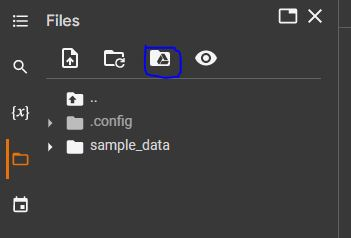

The .json could be read from colab, or you can copy and paste it manually from your local machine to the colab machine.

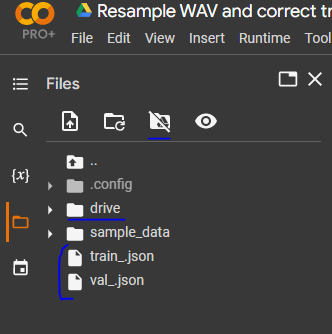


This code look for clips and then generates a transcription with a pretrained ASR NeMo model. Then it compares that transcription with the one in the json with an algorithm called fuzzywuzzy.

The comparision is done over the transcripted text in lower case. Then it print those transcriptions that consider they are not similar and displays the audio to play it. Listen to the audio and correct the .json if neccesary.

It is possible to adjust the sensibility of this similarity measure.

Attention! The transcription in the original .json contains symbols like '%' that are not converted to text 'percent'. 
Also when there is a double space '  ' it's because there is an error.
Also pay attention tu numbers...
Manually verift those cases.





In [1]:
"""
You can either run this notebook locally (if you have all the dependencies and a GPU) or on Google Colab.
Instructions for setting up Colab are as follows:
1. Open a new Python 3 notebook.
2. Import this notebook from GitHub (File -> Upload Notebook -> "GITHUB" tab -> copy/paste GitHub URL)
3. Connect to an instance with a GPU (Runtime -> Change runtime type -> select "GPU" for hardware accelerator)
4. Run this cell to set up dependencies.
"""
# BRANCH = 'main'
# # If you're using Google Colab and not running locally, uncomment and run this cell.
# !apt-get install sox libsndfile1 ffmpeg
# !pip install wget unidecode pynini==2.1.4
# !python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH# egg=nemo_toolkit[all]


import json
# import nemo
# import nemo.collections.asr as nemo_asr
import string

# Initialize NeMo ASR module
# model = nemo_asr.models.ASRModel.from_pretrained(model_name="stt_en_jasper10x5dr")
# model_punctuation = 

!pip install fuzzywuzzy

from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import soundfile as sf
import IPython.display as ipd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.8/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
#This repository provides a transcriber that worked good for me. It also generates punctuation.
!git clone https://github.com/neonbjb/ocotillo.git
!cd ocotillo && pip install -r requirements.txt

# Requirements for recording audio from webcam
!pip uninstall -y ffmpeg
!pip install ffmpeg-python

import os
os.chdir('ocotillo')

from ocotillo.api import Transcriber
transcriber = Transcriber(on_cuda=False)

In [ ]:
# path to json file
name_json = '/content/train_.json'

# If punctuation should be removed for analysis
remove_punctuation = False

# Colab stops execution after processing too much files. With 'folder' as filter it is possible to review one by one folder or file.
folder = ''

# Thersholds to define sensibilit. 100 = perfect match.
threshold_small_difference = 92 # 100 is perfect match
threshold_medium_difference = 82

# Minimum duration tu analyze audios.
min_duration=0.6

# With start = True then the complete folder is going to be analyzed.
# In case that the job is interrupted, it is possible with Start = False and start_from = 'file-name.wav' to start from that file.
start = True
start_from = ''

transcriptions = []
texts_json = []

small_difference_json = []
small_difference_transcription = []
small_difference_filepath = []
medium_difference_json = []
medium_difference_transcription = []
medium_difference_filepath = []
big_difference_json = []
big_difference_transcription = []
big_difference_filepath = []

# Load JSON file
with open(name_json) as f: 
  for i, line in enumerate(f):
    data = json.loads(line)
    if start_from in data['audio_filepath']:
      start=True
    if folder in data['audio_filepath'] and data['duration']>min_duration and start==True:
      # Transcribe audio file
      # transcription=model.transcribe(paths2audio_files=[data['audio_filepath']])[0].lower()
      s,sr=sf.read(data['audio_filepath'])
      transcription=transcriber.transcribe(s,sr)
      text_json=data['text_normalized'].lower()

      if transcription != text_json:
        ratio = fuzz.ratio(text_json,transcription)
        if ratio >= threshold_small_difference:
          small_difference_json.append(text_json)
          small_difference_transcription.append(transcription)
          small_difference_filepath.append(data['audio_filepath'])
        elif ratio >= threshold_medium_difference:
          medium_difference_json.append(text_json)
          medium_difference_transcription.append(transcription)
          medium_difference_filepath.append(data['audio_filepath'])
          print('----- text in json: ', text_json)
          print('----- text predict: ', transcription)
          print('----- ' + data['audio_filepath'])
          ipd.display(ipd.Audio(s, rate=44100))
        elif ratio <threshold_medium_difference:
          big_difference_json.append(text_json)
          big_difference_transcription.append(transcription)
          big_difference_filepath.append(data['audio_filepath'])
          print('# # # # # text in json: ', text_json)
          print('# # # # # text predict: ', transcription)
          print('# # # # # ' + data['audio_filepath'])
          ipd.display(ipd.Audio(s, rate=44100))


# Analize integrity of .json

In [ ]:
# test if the file can be read.

name_json = '/content/train_.json'
with open(name_json) as f: 
  for i, line in enumerate(f):
    data = json.loads(line)
  print(i, 'rows')

#Filter clips according to it's quality

Normally a person does not pronounce perfectly... Also clips can be noissy, the person breaths or stutters while talking.

In the other hand, the transcriptor is not perfect and can make mistakes, especially when transcribing names or acronyms.

Let's assume that if two persons are listening and they understand the same... The pronunciation is good.

We can think the same with two different transcriptors. If they transcribe the same, then the clip is a good sample.

Next code reads the .json manifest, and generates a transcription according to the audio file. If the transcription is similar then it saves it in an other .json. If not, then the clip is discarded.

In [ ]:
# Esta linea de código es para generar un nuevo json que solo contenga aquellas transcripciones buenas. osea las que coinciden bastante con el transcriptor.
from tqdm import tqdm

# path to json file
name_json = '/content/train.json'
name_json_save = '/content/train_.json'

# If punctuation should be removed for analysis
remove_punctuation = True


# Thersholds to define sensibilit. 100 = perfect match.
threshold_small_difference = 97 # 100 is perfect match . A sentence with 20 words compared with other that has a missing word can have a ratio of 96.

# Minimum and maximum duration tu analyze audios.
min_duration=1
max_duration=10

symbols_to_remove = list(string.punctuation)

transcriptions = []
texts_json = []

count=0
time_count=0

# Test if the file can be read
with open(name_json) as f: 
  for i, line in enumerate(f):
    data = json.loads(line)
pbar = tqdm(total=i)

# Load JSON file
with open(name_json) as f, open(name_json_save,"w") as f_save: 
  for i, line in enumerate(f):

    data = json.loads(line)

    if data['duration']>min_duration and data['duration']<max_duration:
      s,sr=sf.read(data['audio_filepath'])
      transcription=transcriber.transcribe(s,sr)
      text_json=data['text_normalized'].lower()
      
      if remove_punctuation==True:
        for symbol in symbols_to_remove:
          transcription = transcription.replace(symbol, "")
          text_json = text_json.replace(symbol, "")

      if transcription != text_json:
        ratio = fuzz.ratio(text_json,transcription)
      else:
        ratio=100

      if ratio >= threshold_small_difference:
        data_json = json.dumps(data)
        f_save.write(data_json + '\n')
        count+=1
        time_count+=data['duration']

      pbar.update(1)

print('There are',count,'clips')
print('Total duration is',time_count,'secondss')

In [ ]:
# With this line we can copy the .json to google drive

!cp -r /content/*.json /content/drive/MyDrive/

#Filter disfluent audios

Sometimes the clip does not start or finish in pauses and the words are not completely pronounced. We want to avoid those kind of audios.

Also good samples can be obtained from audios of a person reading, because it's suposed he respect the pauses and entonation. But when audios are made from a radio program on live, the mode the person speaks may be disfluent.

Next code generate different "qualities".

* Ok: Starts and ends in a pause and does not have disfluency. Or only has one feature we want to avoid. Note: if we have enough samples just use perfect samples.

* Q1: Has one feature we want to avoid.

* Q2: Has two.

* Q3: Has three.

Also, if the clip does not end in a pause but the transcription considers there is a punctuation sign, this sign is deleted.

In [ ]:
# This code is to clip .wav samples and regenerate the audio clips if a the audio has a long pause o does not start or end in a pause.

from tqdm import tqdm
import json
import soundfile as sf
import numpy as np

# path to json file
name_json = '/content/train_.json'
name_json_ok = '/content/train_ok.json'
name_json_Q1 = '/content/train_Q1.json'
name_json_Q2 = '/content/train_Q2.json'
name_json_Q3 = '/content/train_Q3.json'


# Sample Rate of audios
fs = 44100

# Window length in s of "small pause". We call "small pause" a space between words in a normal speech
min_window_length_ms = 0.01

# Window length in s of "long pause". We call "long pause" a minimum space between words that should not exist in a normal speech
pause_length_ms = 0.3

# Threshold for low energy. It's compared to the max of the convolved audio.
threshold = 0.2

# Windows lengths in samples
min_window_length = int(min_window_length_ms * fs)
pause_length = int(pause_length_ms * fs)

# Window function
window = np.ones(min_window_length) / float(min_window_length)

transcriptions = []

punctuation_symbols = list(string.punctuation)

count=0
time_count=0

# Test if the file can be read
with open(name_json) as f: 
  for i, line in enumerate(f):
    data = json.loads(line)
pbar = tqdm(total=i)

# Load JSON file
with open(name_json) as f, open(name_json_ok,"w") as f_ok, open(name_json_Q1,"w") as f_Q1, open(name_json_Q2,"w") as f_Q2, open(name_json_Q3,"w") as f_Q3: 
  for i, line in enumerate(f):

    data = json.loads(line)
    s,sr = sf.read(data['audio_filepath'])

    if fs!=sr:
      print('There is an audio with sample rate not as expected. The SR in Hz of audio is:',sr)

    # Convolution
    convolved_audio = np.convolve(np.abs(s), window, "same")
    threshold_ = np.max(convolved_audio)*threshold

    # Find the low energy zones that are at least pause_length_ms long
    not_pause_frames = np.where(convolved_audio > threshold_)[0]
    pause_durations = np.diff(not_pause_frames)
    disfluent_segments = np.where(pause_durations > pause_length)[0]

    clip_type=0
    # If not pause at the beggining 
    if np.mean(np.abs(s[-min_window_length:-1]))>threshold_:
      clip_type+=1

    # If not pause at the end
    if np.mean(np.abs(s[:min_window_length]))>threshold_:
      clip_type+=1
      #If there is not a pause at the end, probably a punctuation symbol at the end makes no sense.
      if data['text_normalized'][-1] in punctuation_symbols:
        data['text_normalized'] = data['text_normalized'][:-1]


    # If long pauses in the clip
    if len(disfluent_segments)>0:
      clip_type+=1

    if clip_type==0 or clip_type==1:
      data_json = json.dumps(data)
      f_ok.write(data_json + '\n')

    if clip_type==1:
      data_json = json.dumps(data)
      f_Q1.write(data_json + '\n')
    elif clip_type==2:
      data_json = json.dumps(data)
      f_Q2.write(data_json + '\n')
    else:
      data_json = json.dumps(data)
      f_Q3.write(data_json + '\n')

    pbar.update(1)

In [ ]:
# Esta linea de código es para generar un nuevo json que solo contenga aquellas transcripciones buenas. osea las que coinciden bastante con el transcriptor.
from tqdm import tqdm
import numpy as np

# path to json file
name_json = '/content/train_mix_105min_44100_.json'
name_json_save = '/content/train_mix_105min_44100__.json'

# If punctuation should be removed for analysis
remove_punctuation = True

# Thersholds to define sensibilit. 100 = perfect match.
threshold_small_difference = 97 # 100 is perfect match

# Minimum and maximum duration tu analyze audios.
min_duration=1
max_duration=10

symbols_to_remove = list(string.punctuation)

transcriptions = []
texts_json = []

count=0
time_count=0

# Test if the file can be read
with open(name_json) as f: 
  for i, line in enumerate(f):
    data = json.loads(line)
pbar = tqdm(total=i)

# Load JSON file
with open(name_json) as f, open(name_json_save,"w") as f_save: 
  for i, line in enumerate(f):

    data = json.loads(line)

    if data['duration']>min_duration and data['duration']<max_duration:
      # Transcribe audio file
      # transcription=model.transcribe(paths2audio_files=[data['audio_filepath']])[0].lower()
      s,sr=sf.read(data['audio_filepath'])

      transcription=transcriber.transcribe(s,sr)
      text_json=data['text_normalized'].lower()
      
      if remove_punctuation==True:
        for symbol in symbols_to_remove:
          transcription = transcription.replace(symbol, "")
          text_json = text_json.replace(symbol, "")

      if transcription != text_json:
        ratio = fuzz.ratio(text_json,transcription)
      else:
        ratio=100

      if ratio >= threshold_small_difference:
        data_json = json.dumps(data)
        f_save.write(data_json + '\n')
        count+=1
        time_count+=data['duration']
      pbar.update(1)

print('There are',count,'files')
print('Total duration is',time_count,'seconds')




#Check audio duratio
n consistency

In [40]:
# Here we validate if the length in the json file is as expected.
from tqdm import tqdm
import numpy as np

# path to json file
name_json = '/content/val_.json'

count=0
time_count=0

# Test if the file can be read
with open(name_json) as f: 
  for i, line in enumerate(f):
    data = json.loads(line)

# Load JSON file
with open(name_json) as f: 
  for i, line in enumerate(f):

    data = json.loads(line)

    s,sr=sf.read(data['audio_filepath'])
    len_dif=np.abs(data['duration']-len(s)/sr)
    if len_dif>0.1:
      print('Length difference of ',len_dif,'s for',data['audio_filepath'])